In [13]:
%matplotlib inline
from IPython.display import Image

In [101]:
import ee
import ee.mapclient

import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

Here we use `EarthEngine` (`ee`) to extract optical data from PROBA-V and Landsat, and precipitation from CHIRPS.

We then extract the data from `ee` to explore the relationships between precipitation and NDVI. 

We run a series of regressions to explore this relationships.

## Connect to EarthEngine

In [20]:
ee.Initialize()

start_time = pd.datetime(2013,2,3)
end_time = pd.datetime(2019,1,1)

## Get the ImageCollection between 2 dates (the datasets from Earth Engine)

In [119]:
# Create an image collection
# USGS Landsat 8 TOA Reflectance (Orthorectified)
l8 = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filterDate(start_time, end_time)

# CHIRPS
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(start_time, end_time)

# PROBA-V C1 Top Of Canopy Daily Synthesis 100m
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(start_time, end_time)

In [120]:
# Point of interest (WORKING WITH TIME SERIES)
point = {'type':'Point', 'coordinates':[-99.545934,20.572173]};

## Convert to Native Python objects (for manipulation)

In [27]:
# Convert image collection to list, extracting the information for the POINT
info_l8 = l8.getRegion(point,500).getInfo()
info_chirps = precipitation.getRegion(point, 500).getInfo()
info_probav = probav.getRegion(point, 500).getInfo()

In [72]:
# EXTRACT LANDSAT DATA

# extract the data from ImageCollection -> List
header = info_l8[0]
data = np.array(info_l8[1:])

# extract timestamps
# get the index for the TIME data
time_idx = header.index('time')
# Landst time from POSIX timestamp
times = [datetime.datetime.fromtimestamp(time/1000) for time in (data[:,time_idx]).astype(int)]

# extract bands
bands = ['B5','B4']
bands_idx = [header.index(band) for band in bands]
y = data[:,bands_idx].astype(np.float)

In [81]:
# Calculate Landsat NDVI
red = y[:,0] #b5
nir = y[:,1] #b4
ndvi = (nir - red)/(nir + red)

ndvi[:5]

array([-0.18351961, -0.19580729, -0.19512432, -0.36823843, -0.30502496])

In [148]:
# NOTE: -ve NDVI required, the calculation for some reason leads to -ves

# create DataFrame 
df = pd.DataFrame(data=-ndvi, index=time, columns=['ndvi_l8'])
l8_ndvi = df.dropna()

# resample monthly
monthly_l8_ndvi = l8_ndvi.resample('M').mean()
monthly_l8_ndvi.head()

,ndvi_l8
2013-04-30,0.149223
2013-05-31,0.177276
2013-06-30,0.261074
2013-07-31,0.349402
2013-08-31,0.252313


In [149]:
# extract CHIRPS precip data
header = info_chirps[0]
data = np.array(info_chirps[1:])

# extract timestamps
# get the index for the TIME data
time_idx = header.index('time')
# CHIRPS time from POSIX timestamp
times = [datetime.datetime.fromtimestamp(time/1000) for time in (data[:,time_idx]).astype(int)]

# extract bands
bands = ['precipitation']
bands_idx = [header.index(band) for band in bands]
chirps = data[:,bands_idx].astype(np.float)

# convert to DataFrame
df = pd.DataFrame(data=chirps, index=times, columns=['precipitation'])
chirps_df = df.dropna()

# resample monthly
monthly_chirps_df = chirps_df.resample('M').mean()

chirps_df.head()

,precipitation
2013-02-06,0.332724
2013-02-11,0.319757
2013-02-16,0.328171
2013-02-21,0.366413
2013-02-26,0.419520


In [150]:
# extract PROBA-V precip data
header = info_probav[0]
data = np.array(info_probav[1:])

# extract timestamps
# get the index for the TIME data
time_idx = header.index('time')
# CHIRPS time from POSIX timestamp
times = [datetime.datetime.fromtimestamp(time/1000) for time in (data[:,time_idx]).astype(int)]

# extract bands
bands = ['NDVI']
bands_idx = [header.index(band) for band in bands]
probav = data[:,bands_idx].astype(np.float)

# convert to DataFrame
df = pd.DataFrame(data=probav, index=times, columns=['ndvi_probaV'])
proba_df = df.dropna()

# resample monthly
monthly_proba_df = proba_df.resample('M').mean()

monthly_proba_df.head()

,ndvi_probaV
2014-03-31,86.333333
2014-04-30,76.500000
2014-05-31,57.285714
2014-06-30,65.800000
2014-07-31,115.000000


## Compare the different datasets

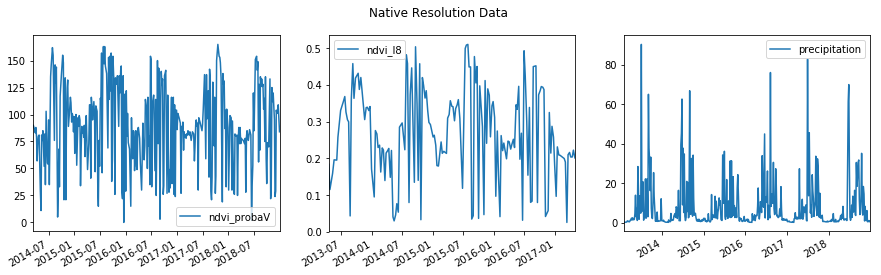

In [151]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
proba_df.plot(ax=ax1)
l8_ndvi.plot(ax=ax2)
chirps_df.plot(ax=ax3)
fig.suptitle('Native Resolution Data');

## Match temporal ranges

In [152]:
monthly_proba_df = monthly_proba_df['2014-04':'2017-04']
monthly_l8_ndvi = monthly_l8_ndvi['2014-04':'2017-04']
monthly_chirps_df = monthly_chirps_df['2014-04':'2017-04']

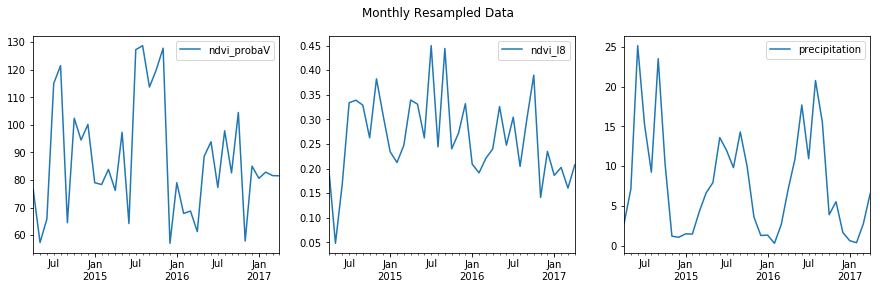

In [153]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
monthly_proba_df.plot(ax=ax1)
monthly_l8_ndvi.plot(ax=ax2)
monthly_chirps_df.plot(ax=ax3)
fig.suptitle('Monthly Resampled Data');

## Create one DataFrame

In [154]:
data = {"probav":monthly_proba_df['ndvi_probaV'],
"landsat":monthly_l8_ndvi['ndvi_l8'],
"chirps":monthly_chirps_df['precipitation'],}

monthly = pd.DataFrame(data, index=monthly_proba_df.index)
monthly.head()
# (monthly_l8_ndvi.index == monthly_proba_df.index ) & (monthly_proba_df.index == monthly_chirps_df.index)

,probav,landsat,chirps
2014-04-30,76.500000,0.204313,2.745935
2014-05-31,57.285714,0.048045,7.124044
2014-06-30,65.800000,0.169142,25.150503
2014-07-31,115.000000,0.333831,15.250196
2014-08-31,121.500000,0.339043,9.242385


## Bivariate Relationships

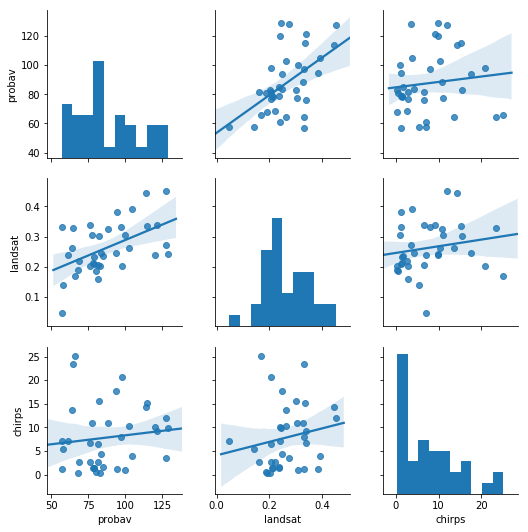

In [156]:
# sns.pairplot(monthly, x_vars=['chirps'], y_vars=['landsat','probav'])
g = sns.PairGrid(monthly)
g = g.map_diag(plt.hist)
g = g.map_offdiag(sns.regplot) # plt.scatter
fig = plt.gcf()

## Run the regressions!

### Using Statsmodels

In [184]:
# Statsmodels
lm_1 = smf.ols(formula='chirps ~ landsat', data=monthly).fit()

# Print the coefficients
print(lm_1.params)
lm_1.summary()

Intercept     4.081701
landsat      14.312617
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 chirps   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.141
Date:                Wed, 20 Feb 2019   Prob (F-statistic):              0.293
Time:                        00:08:01   Log-Likelihood:                -122.10
No. Observations:                  37   AIC:                             248.2
Df Residuals:                      35   BIC:                             251.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0817      3.701      1.103      0.278      -3.431      11.594
landsat       14.3126     13.397      1.068      0.293     -12.884      41.509
==============================================================================
Omnibus:                        8.046   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.963
Skew:                           1.027   Prob(JB):                       0.0308
Kurtosis:                       3.547   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using scikit-learn

In [159]:
X = monthly.landsat.values.reshape(-1,1)
y = monthly.chirps

# instantiate and fit
lm_2 = LinearRegression()
lm_2.fit(X, y)

# print the coefficients
print('Intercept: ', lm_2.intercept_)
print('landsat: ', lm_2.coef_)

Intercept:  4.081700556631772
landsat:  [14.31261718]


### Using seaborn

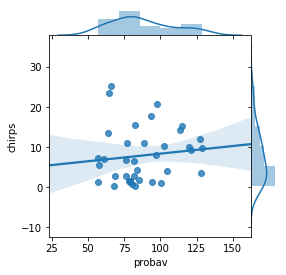

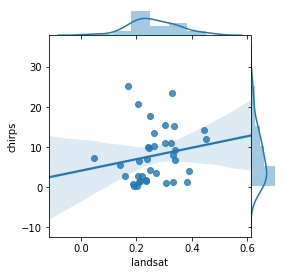

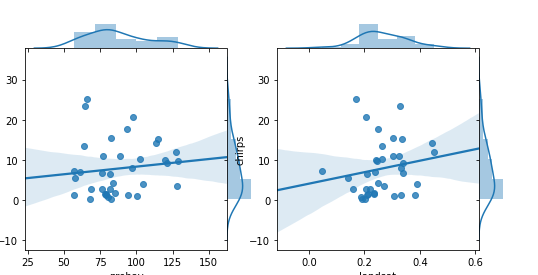

In [178]:
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
plt1 = sns.jointplot("probav", "chirps", data=monthly, height=7, kind='reg'); #,ax=ax1)
plt2 = sns.jointplot("landsat", "chirps", data=monthly, height=7, kind='reg'); #,ax=ax2)

f = plt.figure()

for plot in [plt1, plt2]:
    for A in plot.fig.axes:
        f._axstack.add(f._make_key(A), A)

f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

## Explore the Temporal Trends using Linear Model

In [ ]:
# plotting images from EE
url = l8.draw('#000000').getThumbUrl({'min':0, 'max':1000})
Image(url=url)

### landsat:
* B1 Coastal aerosol
* B2 Blue
* B3 Green
* B4 Red
* B5 Near infrared
* B6 Shortwave infrared 1
* B7 Shortwave infrared 2
* B8 Panchromatic
* B9 Cirrus
* B10 Thermal infrared 1, resampled from 100m to 30m
* B11 Thermal infrared 2, resampled from 100m to 30m
* BQA Landsat Collection 1 QA Bitmask (See Landsat QA page)

### proba-v:
* RED Top of canopy reflectance RED channel
* NIR Top of canopy reflectance NIR channel
* BLUE Top of canopy reflectance BLUE channel
* SWIR Top of canopy reflectance SWIR channel
* NDVI Normalized Difference Vegetation Index
* SZA	Degrees Solar zenith angle
* SAA	Degrees Solar azimuth angle
* SWIRVAA	Degrees Viewing azimuth angles SWIR detector
* SWIRVZA	Degree Viewing zenith angle SWIR detector
* VNIRVAA	Degrees Viewing azimuth angle VNIR detector
* VNIRVZA	Degrees Viewing zenith angle VNIR detector
* SM Quality / Information band.